In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

import shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import Latex, Markdown

In [38]:
from data_model import DataModel

In [39]:
seed = 1

np.random.seed(seed)

N = 1000

In [40]:
class DataModelInteraction(DataModel):
    def __init__(self, N: int):
        self.x_1 = np.random.uniform(-1, 1, N)
        self.x_2 = np.random.uniform(-1, 1, N)
        self.eps = np.random.normal(0, 0.01, N)

        super().__init__(N)

    def generate_x(self) -> pd.DataFrame:
        X = pd.DataFrame({
            "X_1": self.x_1,
            "X_2": self.x_2,
        })
        return X

    def calculate_y(self, X: pd.DataFrame) -> np.ndarray:
        y = 0.3 * X["X_1"] - 17 * X["X_1"] * X["X_2"] + self.eps
        return y

    def true_predictions(self, feature: str, X: pd.DataFrame) -> np.ndarray:
        return super().true_predictions(feature, X)

    def __str__(self) -> str:
        x_1_str = "$x_1 \sim \mathbb U(-1, 1)$"
        x_2_str = "$x_2 \sim \mathbb U(-1, 1)$"
        eps_str = "$\epsilon \sim \mathbb N(0, 0.01)$"
        y_str = "$y = 0.3 \cdot x_1 - 17 \cdot x_1 \cdot x_2 + \epsilon$"
        return "\n".join([y_str, x_1_str, x_2_str, eps_str])


In [41]:
class DataModelDependence(DataModel):
    def __init__(self, N: int):
        self.x_1 = np.random.uniform(0, 1, N)
        self.x_2 = np.random.uniform(0, 1, N)
        self.eps = np.random.normal(0, 0.04, N)
        self.x_3 = 0.6 * self.x_2 + self.eps

        super().__init__(N)

    def generate_x(self) -> pd.DataFrame:
        X = pd.DataFrame({
            "X_1": self.x_1,
            "X_2": self.x_2,
            "X_3": self.x_3,
        })
        return X

    def calculate_y(self, X: pd.DataFrame) -> np.ndarray:
        y = 0.8 * X["X_1"] - 0.3 * X["X_2"] + 0.7 * X["X_3"] + self.eps
        return y

    def true_predictions(self, feature: str, X: pd.DataFrame) -> np.ndarray:
        if feature == "X_2":
            X["X_3"] = 0.6 * X["X_2"] + self.eps
        return self.calculate_y(X)

    def __str__(self) -> str:
        x_1_str = "$x_1 \sim \mathbb U(0, 1)$"
        x_2_str = "$x_2 \sim \mathbb U(0, 1)$"
        x_3_str = "$x_3 \sim x_2 \cdot \epsilon$"
        eps_str = "$\epsilon \sim \mathbb N(0, 0.04)$"
        y_str = "$y = 0.8 \cdot x_1 - 0.3 \cdot x_2 + 0.7 \cdot x_3 + \epsilon$"
        return "\n".join([y_str, x_1_str, x_2_str, x_3_str, eps_str])


In [42]:
class DataModelConfounding(DataModel):
    def __init__(self, N: int):
        self.x_1 = np.random.uniform(0, 2, N)
        self.eps = np.random.normal(0, 0.04, N)
        self.x_2 = 3 * self.x_1 + self.eps

        super().__init__(N)

    def generate_x(self) -> pd.DataFrame:
        X = pd.DataFrame({
            "X_1": self.x_1,
            "X_2": self.x_2,
        })
        return X

    def calculate_y(self, X: pd.DataFrame) -> np.ndarray:
        y = X["X_2"] - X["X_1"] ** 2 + self.eps
        return y

    def true_predictions(self, feature: str, X: pd.DataFrame) -> np.ndarray:
        if feature == "X_1":
            X["X_2"] = 3 * X["X_1"] + self.eps
        return self.calculate_y(X)

    def __str__(self) -> str:
        x_1_str = "$x_1 \sim \mathbb U(0, 2)$"
        x_2_str = "$x_2 \sim 3 \cdot x_1 + \epsilon$"
        eps_str = "$\epsilon \sim \mathbb N(0, 0.04)$"
        y_str = "$y = x_2 - x_1^2 + \epsilon$"
        return "\n".join([y_str, x_1_str, x_2_str, eps_str])


In [43]:
class DataModelReversedCausality(DataModel):
    def __init__(self, N: int):
        self.x_1 = np.random.uniform(0, 1, N)
        self.x_2 = np.zeros(N)

        super().__init__(N)

        self.x_2 = self.y ** 2

    def generate_x(self) -> pd.DataFrame:
        X = pd.DataFrame({
            "X_1": self.x_1,
            "X_2": self.x_2,
        })
        return X

    def calculate_y(self, X: pd.DataFrame) -> np.ndarray:
        y = 4 * X["X_1"]
        return y

    def true_predictions(self, feature: str, X: pd.DataFrame) -> np.ndarray:
        return super().true_predictions(feature, X)

    def __str__(self) -> str:
        x_1_str = "$x_1 \sim \mathbb U(0, 1)$"
        x_2_str = "$x_2 \sim y^2$"
        y_str = "$y = 4 \cdot x_1$"
        return "\n".join([y_str, x_1_str, x_2_str])


In [44]:
class DataModelUnusedVar(DataModel):
    def __init__(self, N: int):
        self.x_1 = np.random.uniform(-1, 1, N)
        self.eps = np.random.normal(0, 0.1, N)
        self.x_2 = 8 * self.x_1 + self.eps

        super().__init__(N)

    def generate_x(self) -> pd.DataFrame:
        X = pd.DataFrame({
            "X_1": self.x_1,
            "X_2": self.x_2,
        })
        return X

    def calculate_y(self, X: pd.DataFrame) -> np.ndarray:
        y = 4 * X["X_1"] + self.eps
        return y

    def true_predictions(self, feature: str, X: pd.DataFrame) -> np.ndarray:
        if feature == "X_1":
            X["X_2"] = 8 * X["X_1"] + self.eps
        return self.calculate_y(X)

    def __str__(self) -> str:
        x_1_str = "$x_1 \sim \mathbb U(-1, 1)$"
        x_2_str = "$x_2 \sim 8 \cdot x_1 + \epsilon$"
        eps_str = "$\epsilon \sim \mathbb N(0, 0.1)$"
        y_str = "$y = 4 \cdot x_1 + \epsilon$"
        return "\n".join([y_str, x_1_str, x_2_str, eps_str])


In [45]:
ml_models = [
        RandomForestRegressor(n_estimators=100, random_state=seed),
        SVR(kernel="rbf"),
        MLPRegressor(solver="adam", max_iter=1000, random_state=seed),
]

In [46]:
data_models = [
    DataModelInteraction(N),
    DataModelDependence(N),
    DataModelConfounding(N),
    DataModelReversedCausality(N),
    DataModelUnusedVar(N),
]

In [47]:
def run_experiments(ml_models: list, data_models: list):
    for data_model in data_models:
        print("-" * 150)
        display(Markdown(f"# {data_model.__class__.__name__}"))
        display(Latex(str(data_model)))

        features = data_model.get_feature_names()


        for ml_model in ml_models:
            ml_model.fit(data_model.X, data_model.y)
            score = ml_model.score(data_model.X, data_model.y)

            print(f"{ml_model.__class__.__name__} score: {score}")


            explainer = shap.Explainer(ml_model.predict, data_model.X)
            shap_values = explainer(data_model.X)
            sample_ind = 15

            for feature in features:
                data_model.plot_true_and_total_dp(feature, ml_model)
                shap.plots.scatter(shap_values[:, feature], color=shap_values)

            shap.plots.waterfall(shap_values[sample_ind], max_display=14)

            shap.plots.bar(shap_values.abs.max(0))

            shap.plots.beeswarm(shap_values)

            print("." * 150)


------------------------------------------------------------------------------------------------------------------------------------------------------


# DataModelInteraction

<IPython.core.display.Latex object>

RandomForestRegressor score: 0.9983859763501246


Exact explainer: 1001it [00:13, 18.67it/s]                         


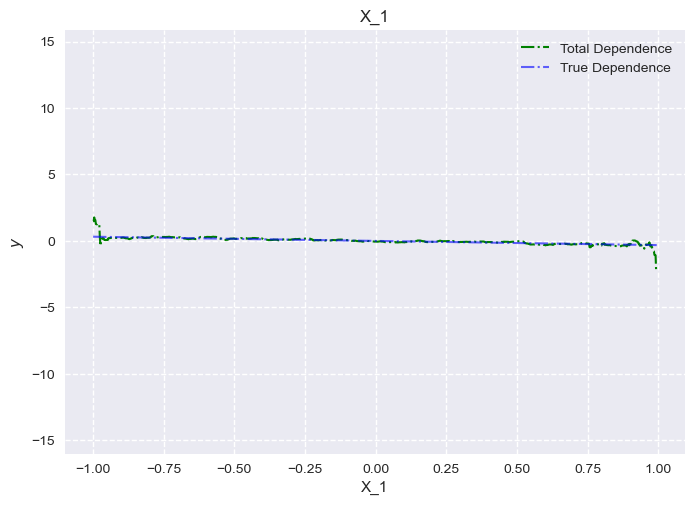

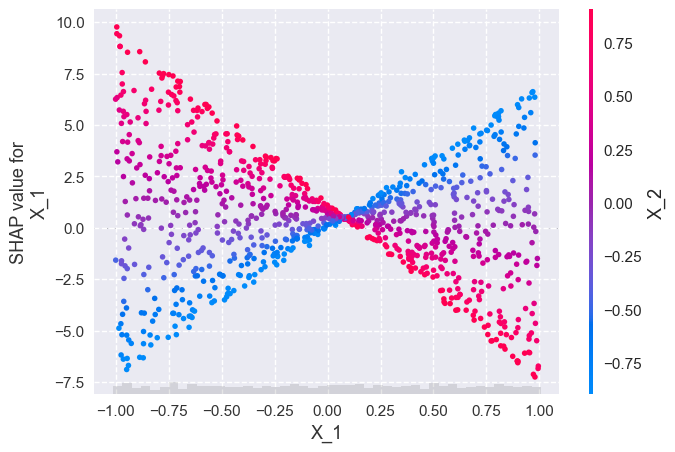

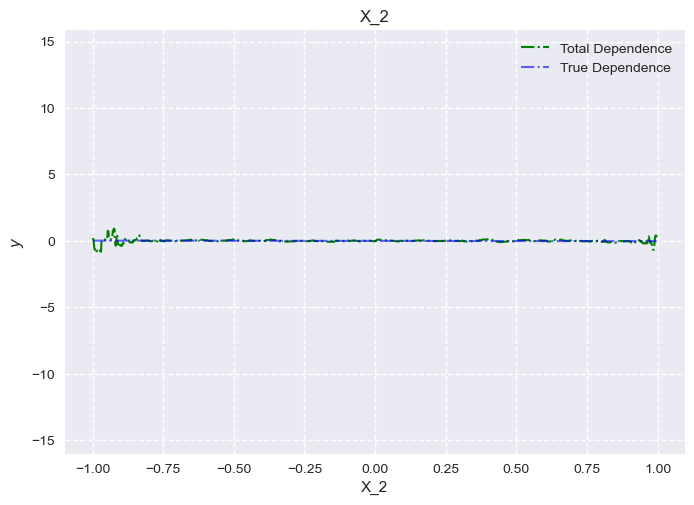

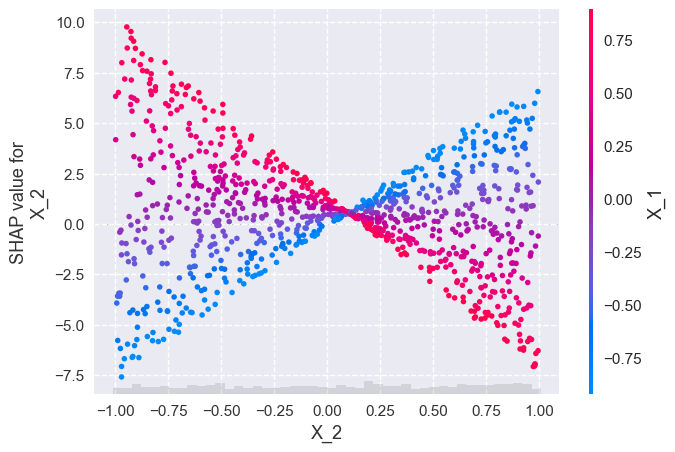

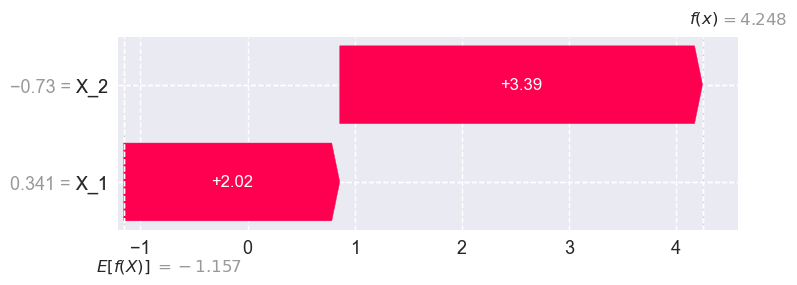

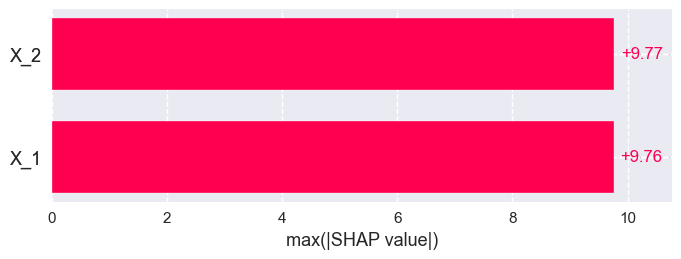

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


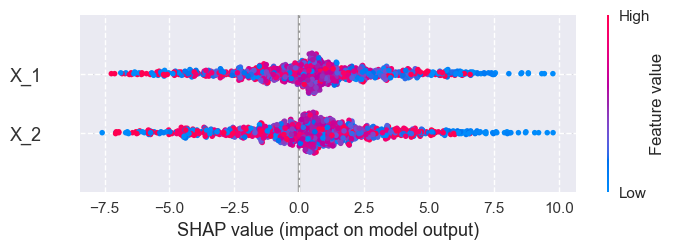

......................................................................................................................................................
SVR score: 0.9937525664667479


Exact explainer: 1001it [00:10,  5.01s/it]                 


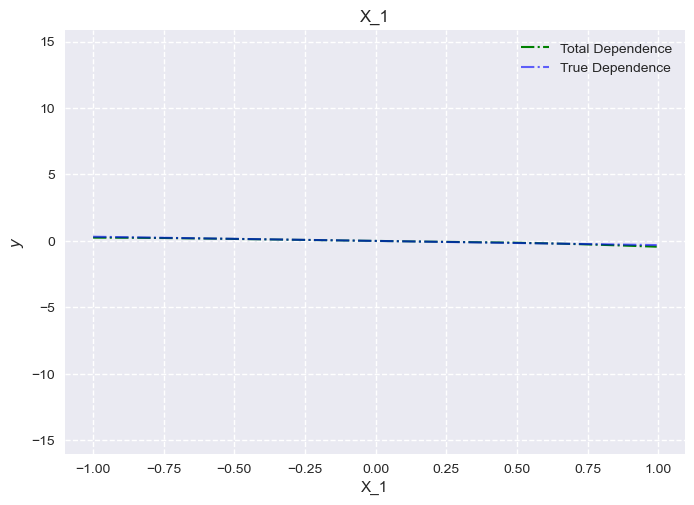

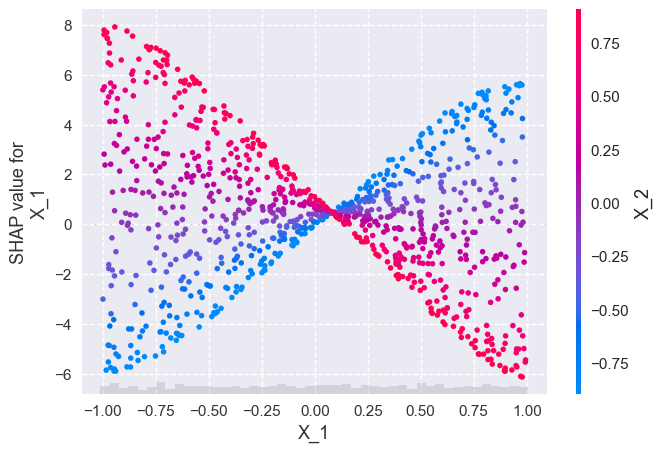

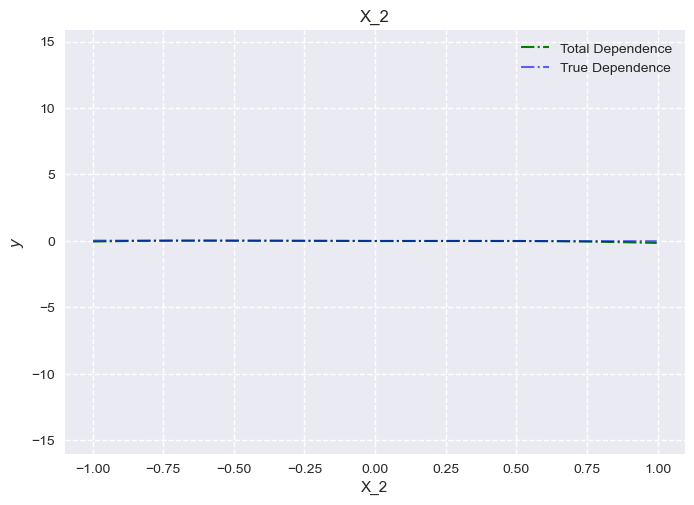

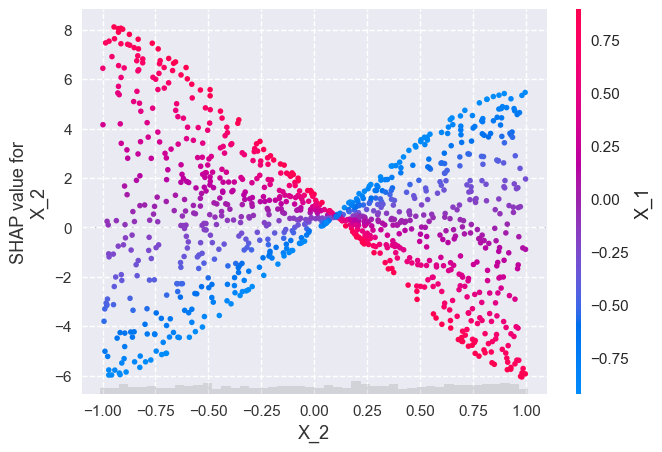

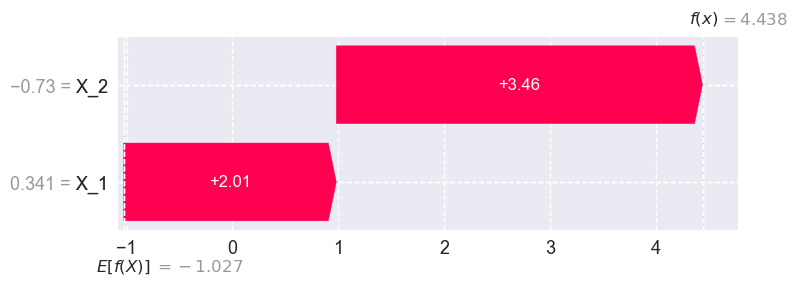

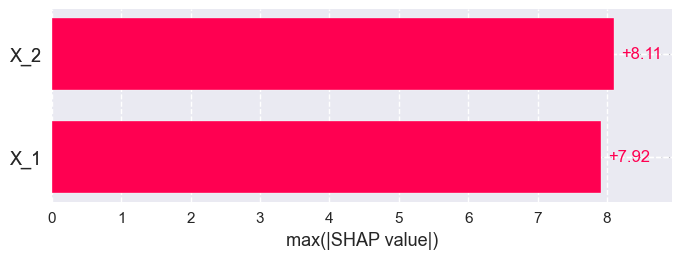

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


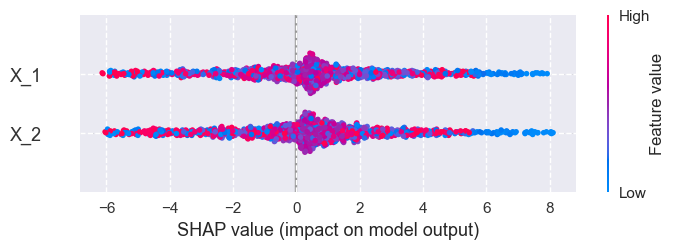

......................................................................................................................................................
MLPRegressor score: 0.9993959348406136


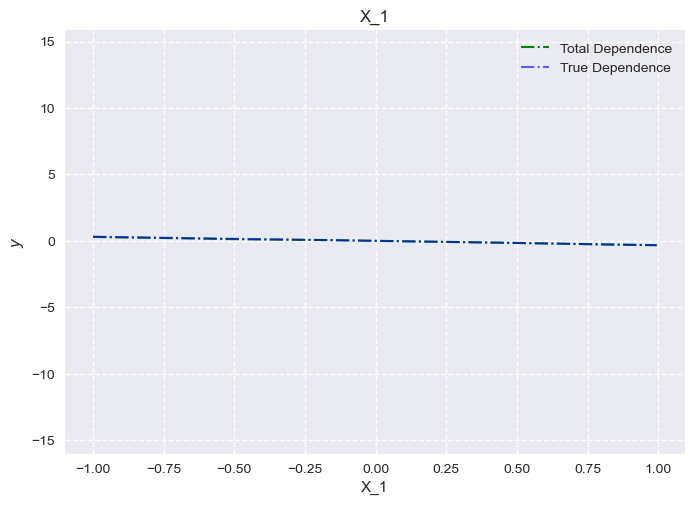

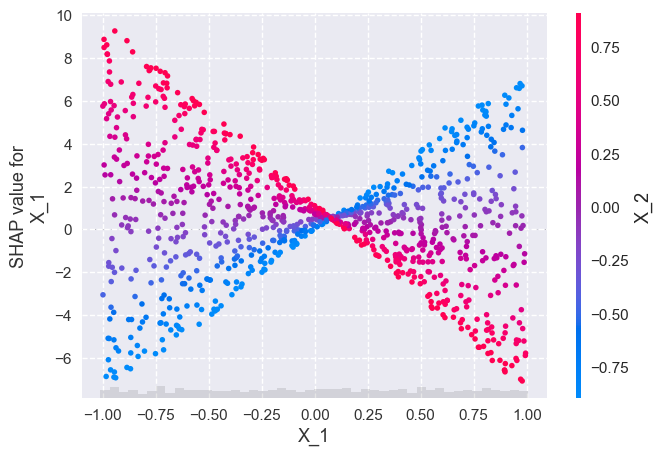

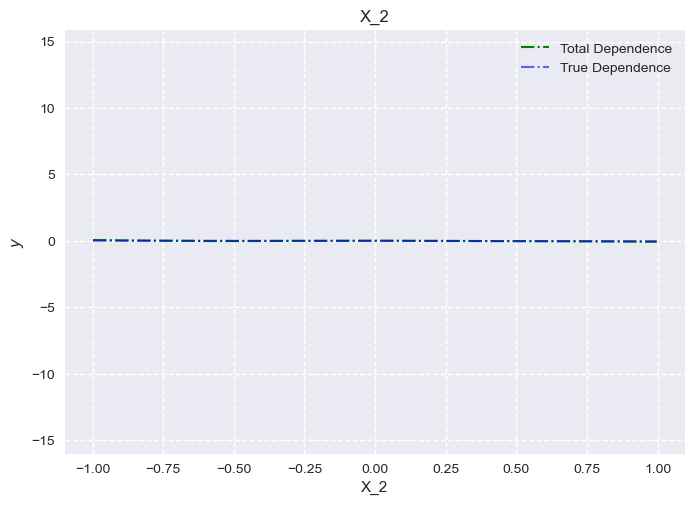

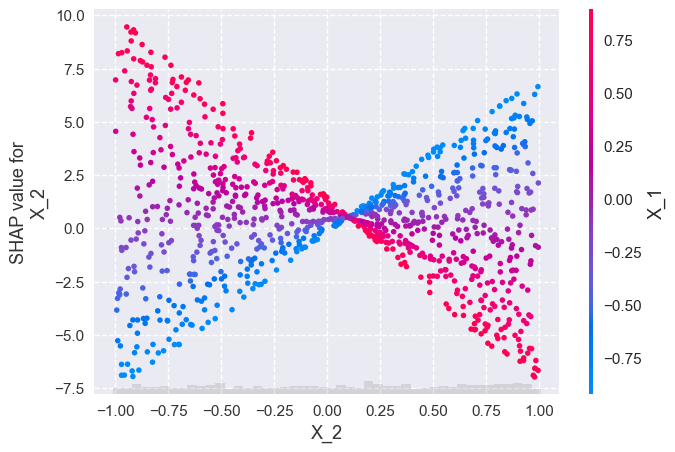

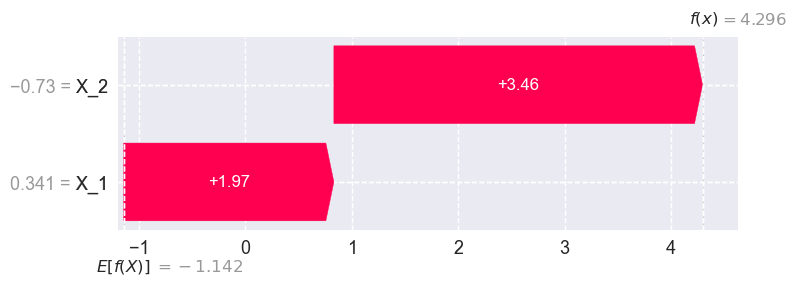

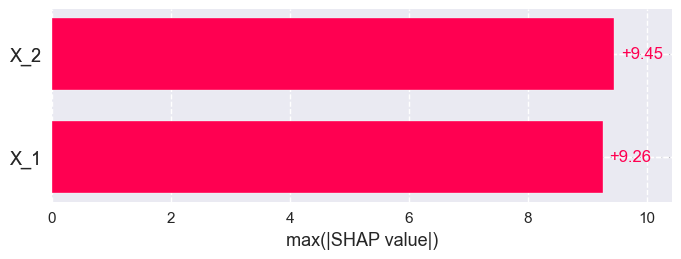

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


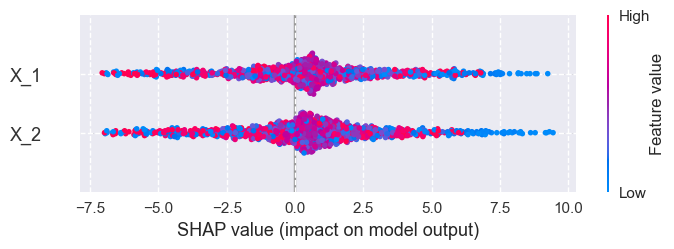

......................................................................................................................................................
------------------------------------------------------------------------------------------------------------------------------------------------------


# DataModelDependence

<IPython.core.display.Latex object>

RandomForestRegressor score: 0.9949780185211528


Exact explainer: 1001it [00:16, 23.87it/s]                         


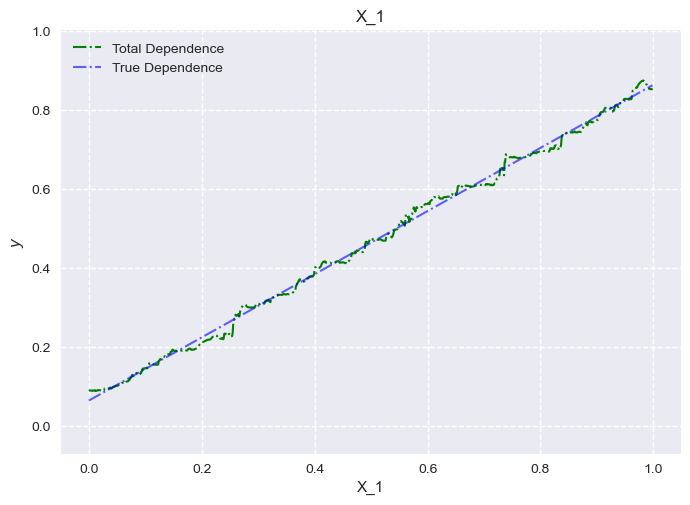

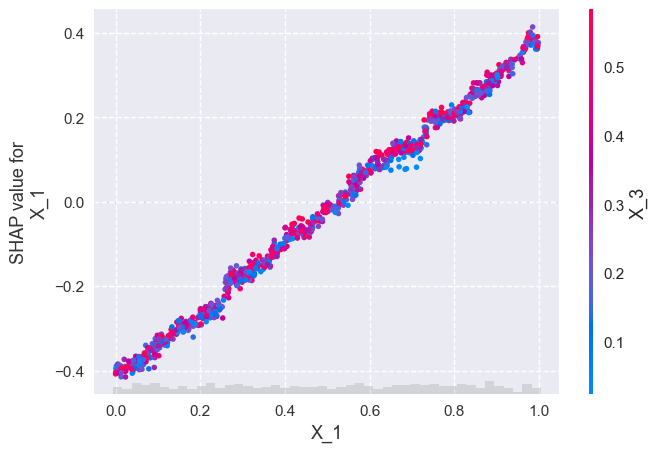

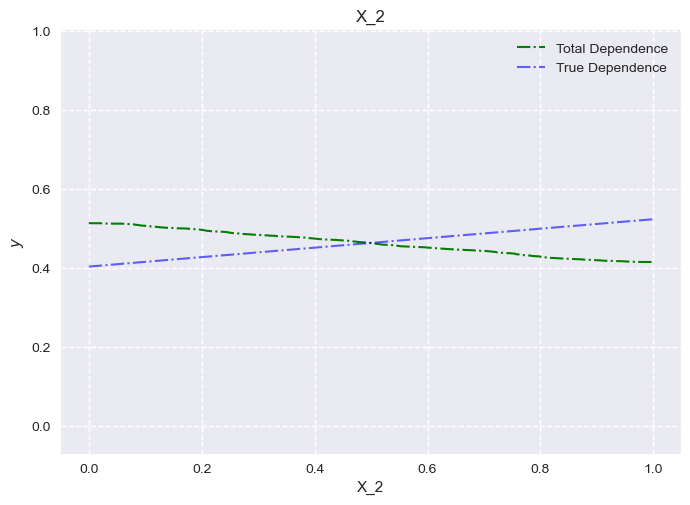

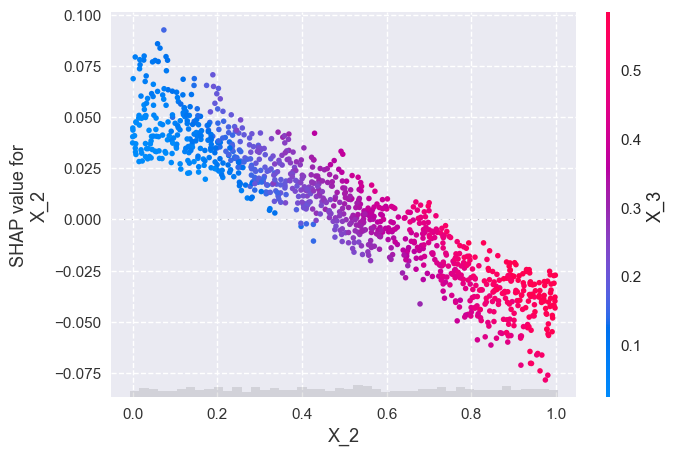

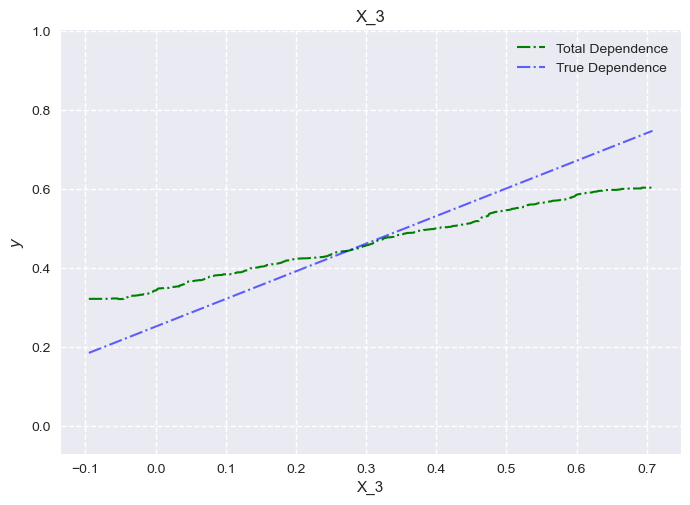

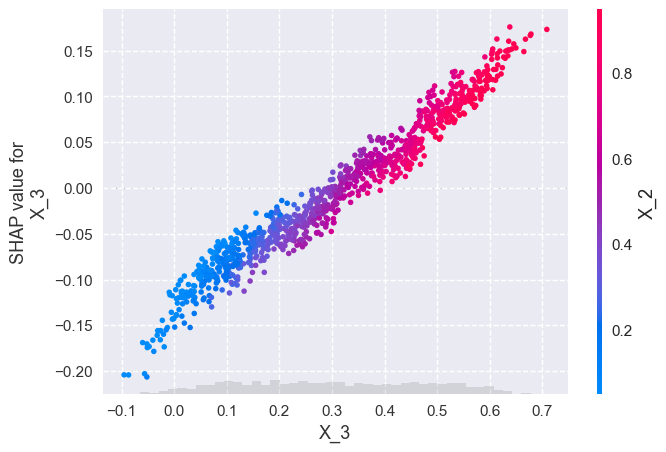

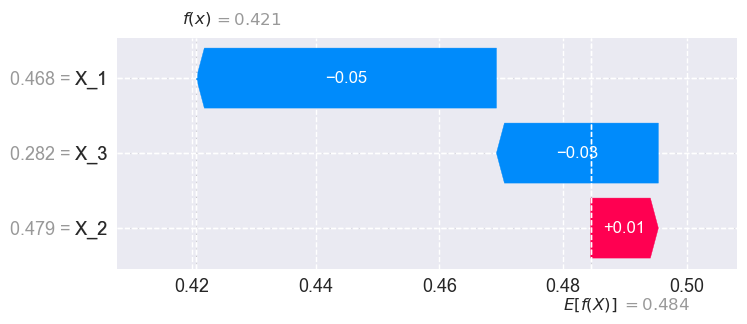

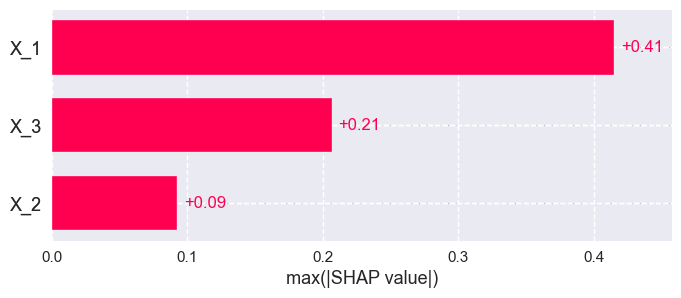

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


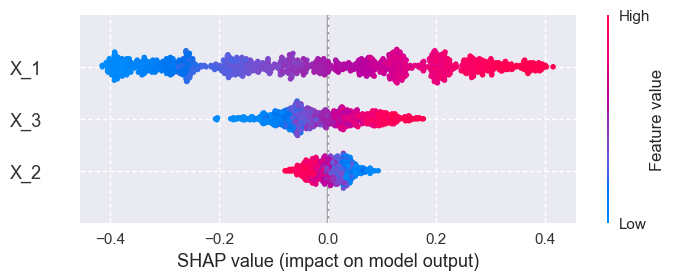

......................................................................................................................................................
SVR score: 0.9728703659287697


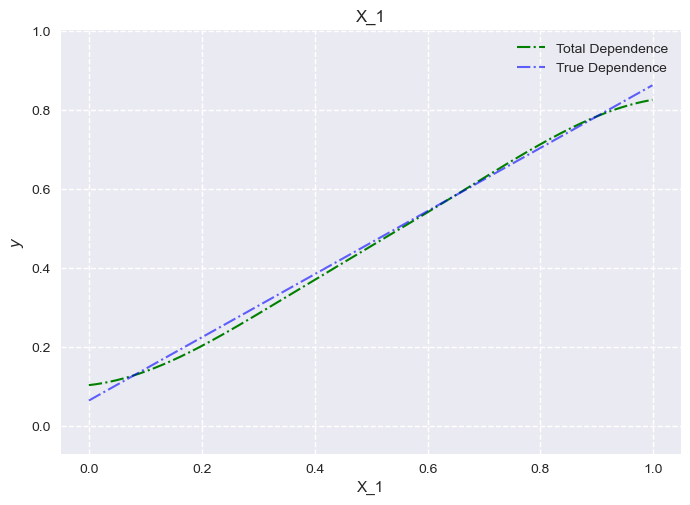

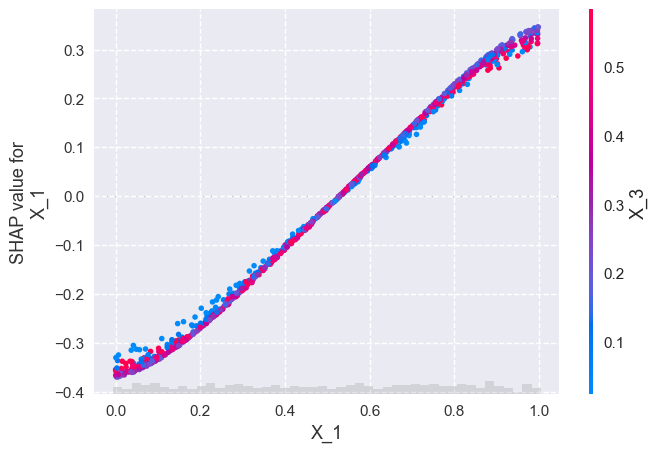

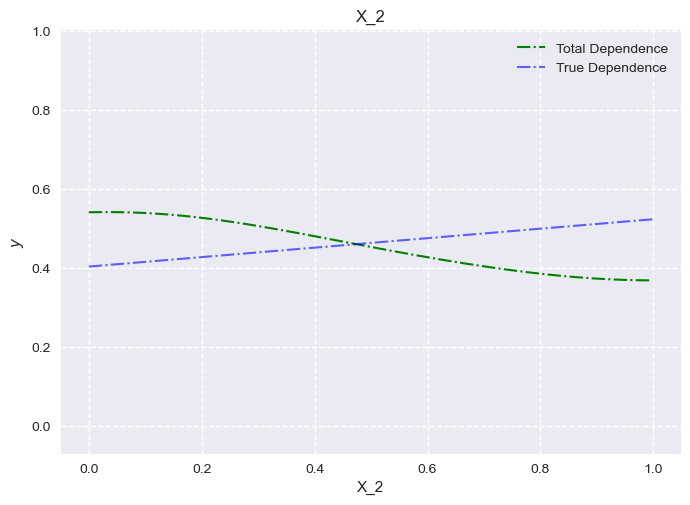

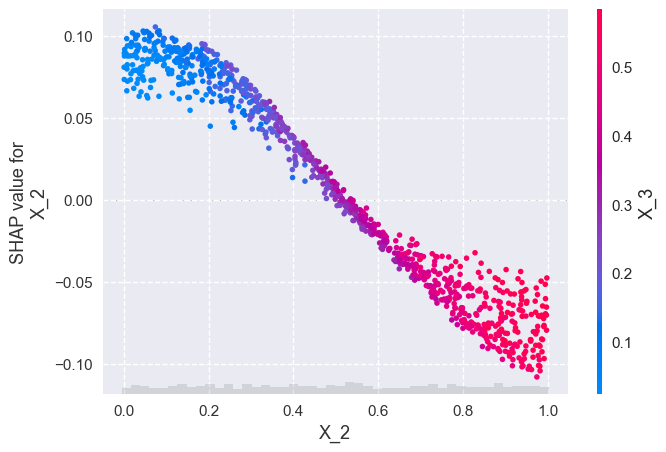

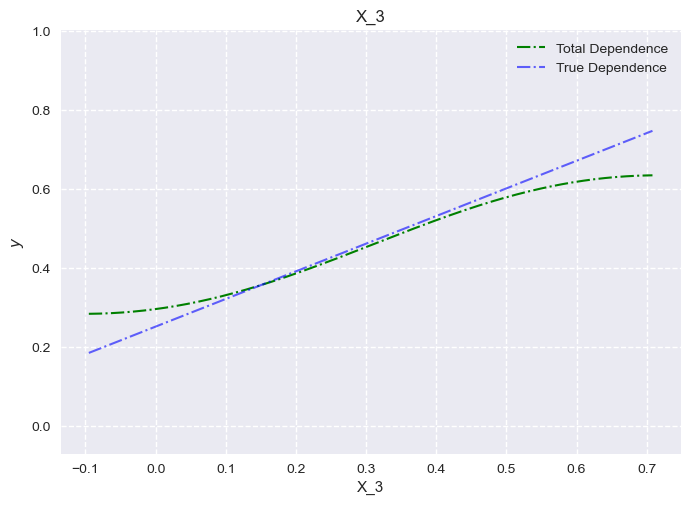

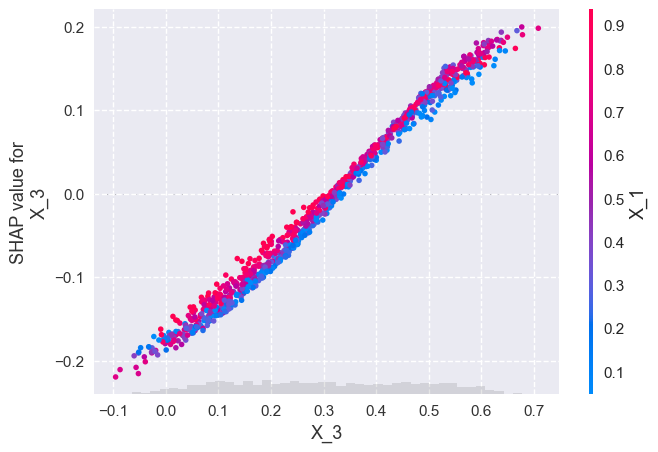

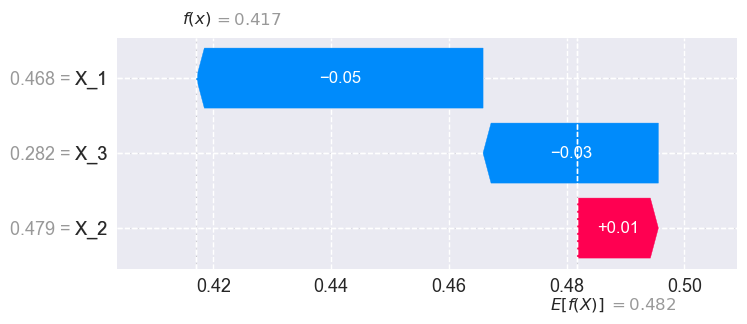

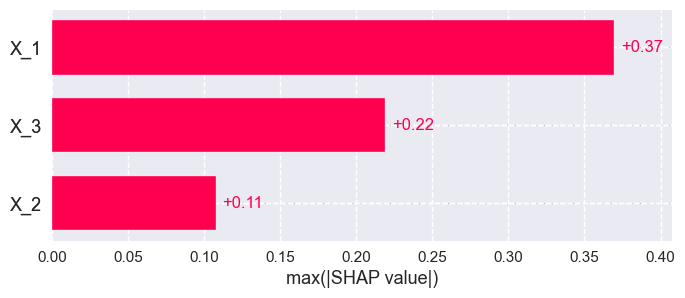

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


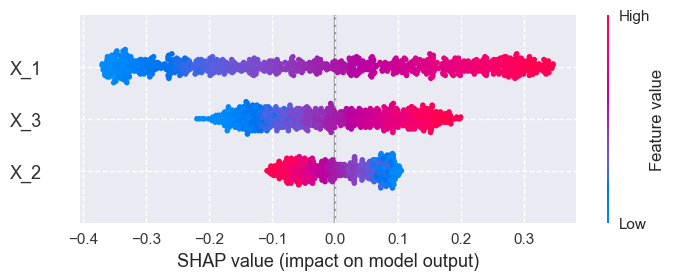

......................................................................................................................................................
MLPRegressor score: 0.9371202771132991


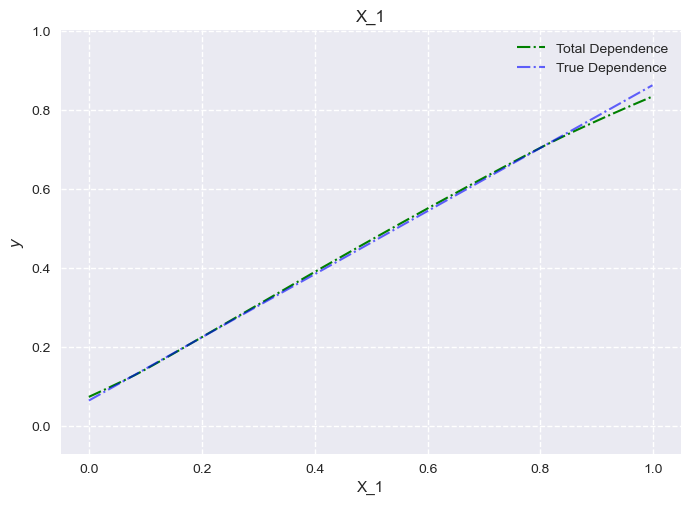

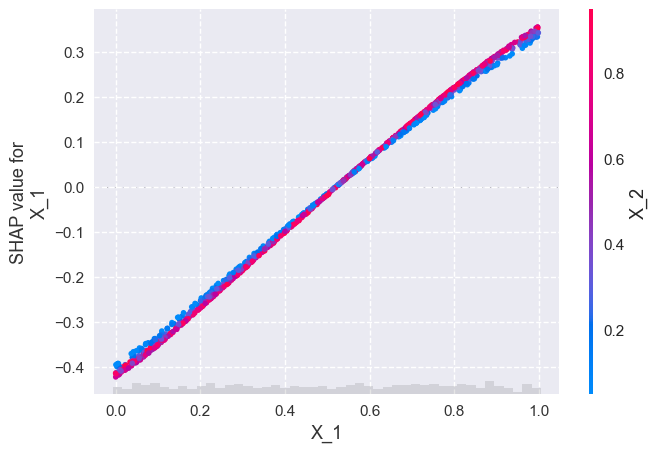

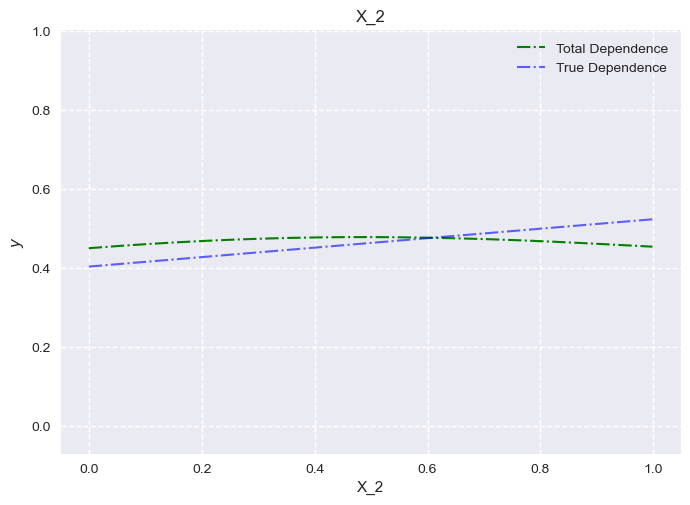

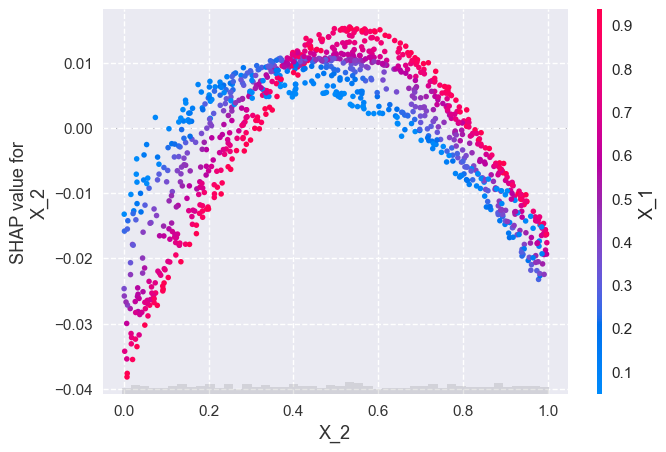

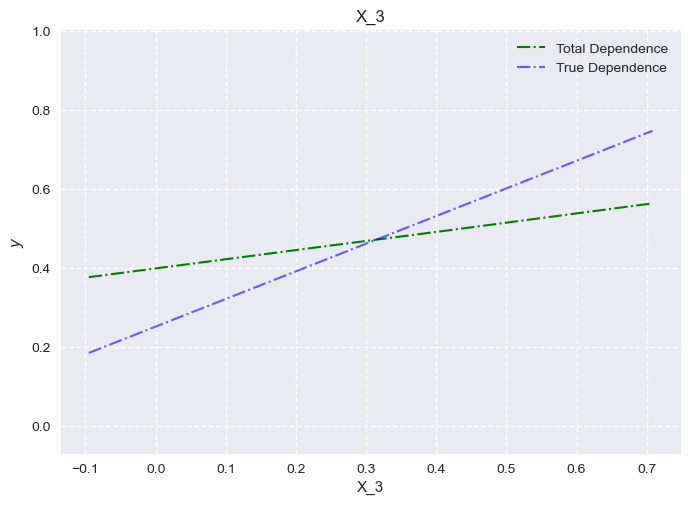

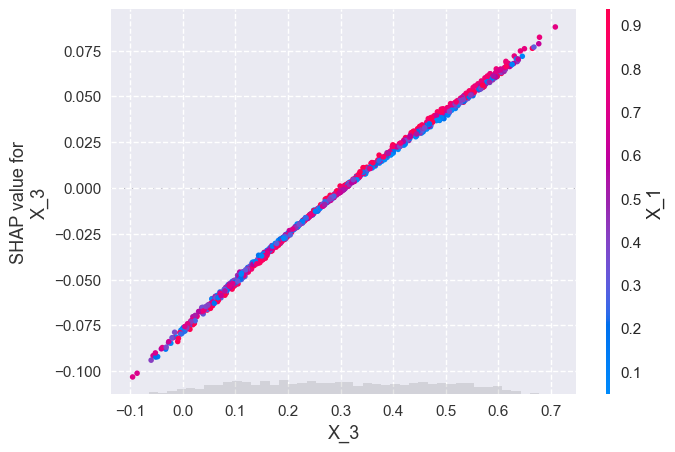

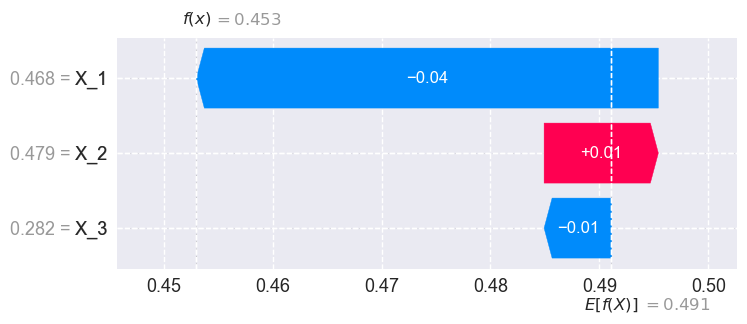

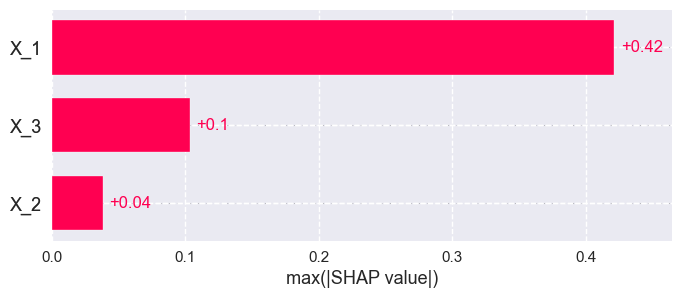

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


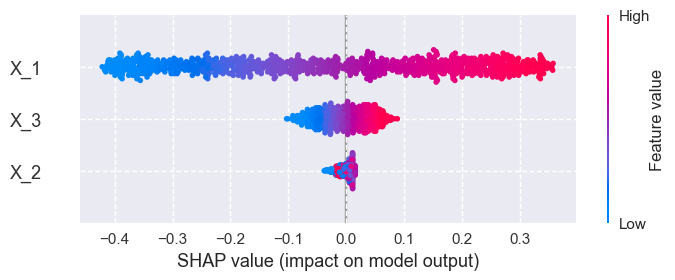

......................................................................................................................................................
------------------------------------------------------------------------------------------------------------------------------------------------------


# DataModelConfounding

<IPython.core.display.Latex object>

RandomForestRegressor score: 0.9993797254701469


Exact explainer: 1001it [00:12, 16.54it/s]                         


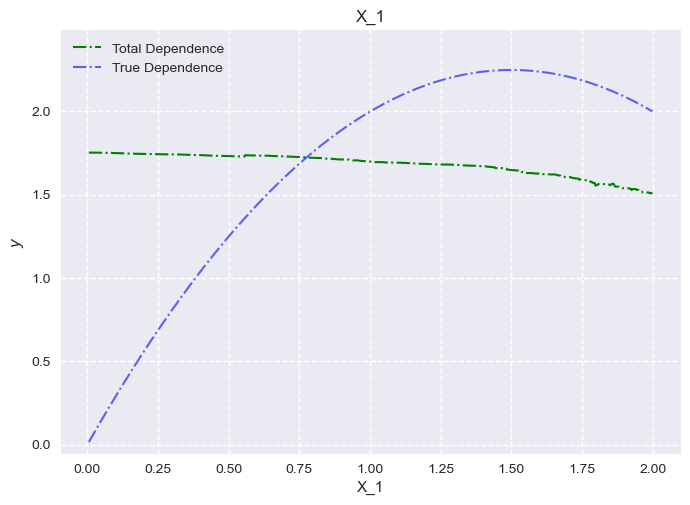

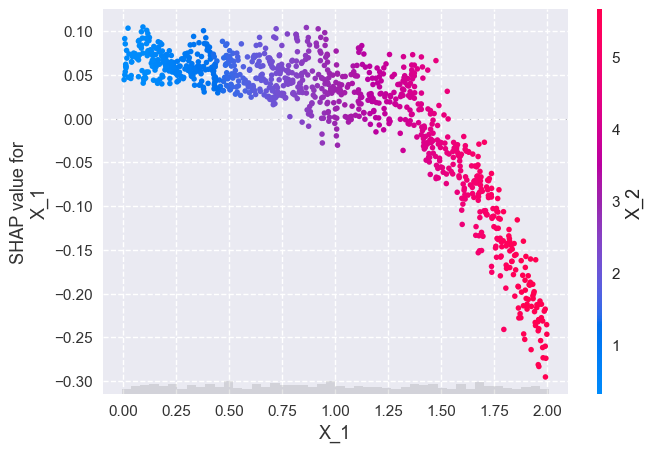

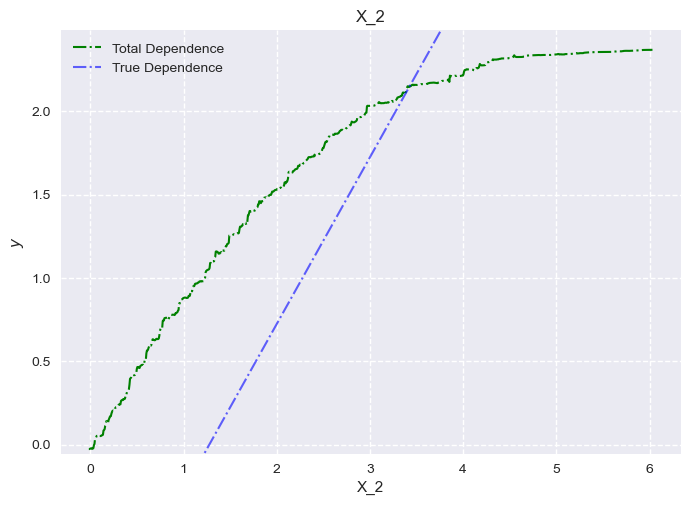

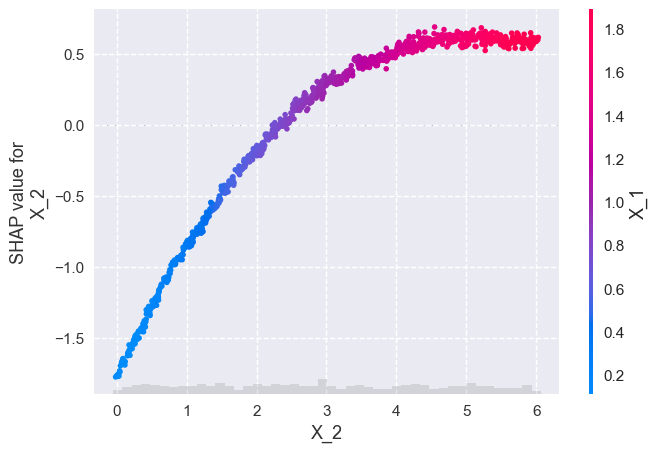

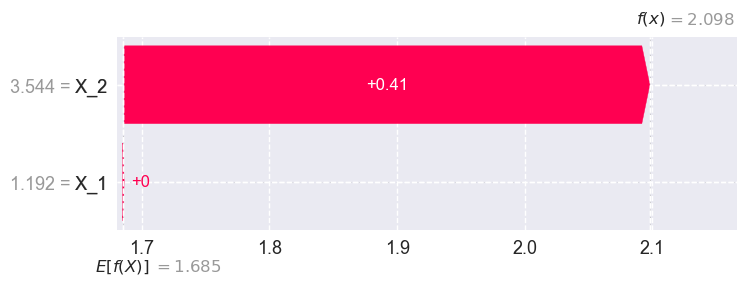

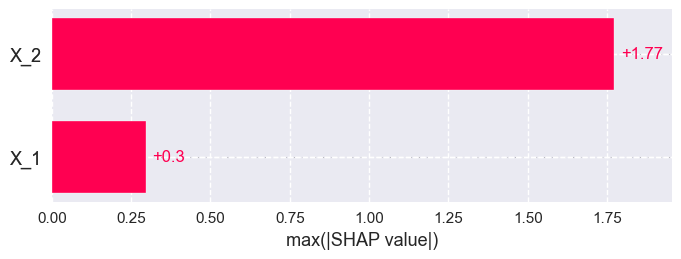

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


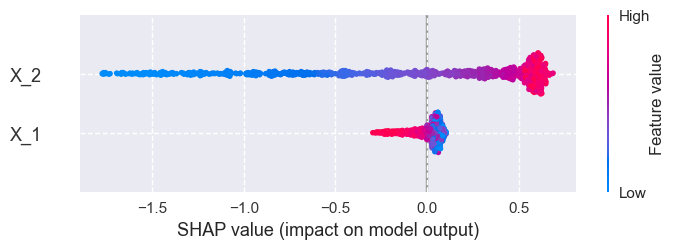

......................................................................................................................................................
SVR score: 0.990771550747634


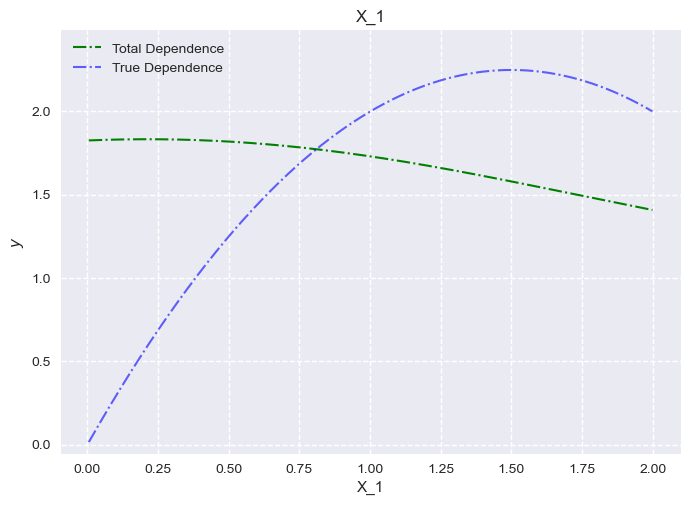

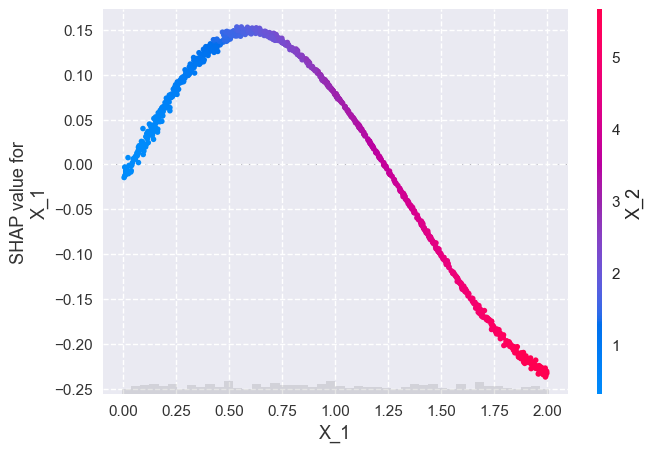

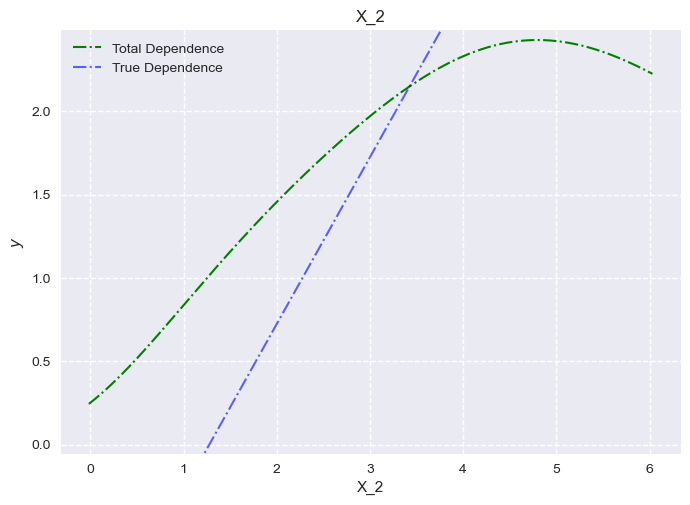

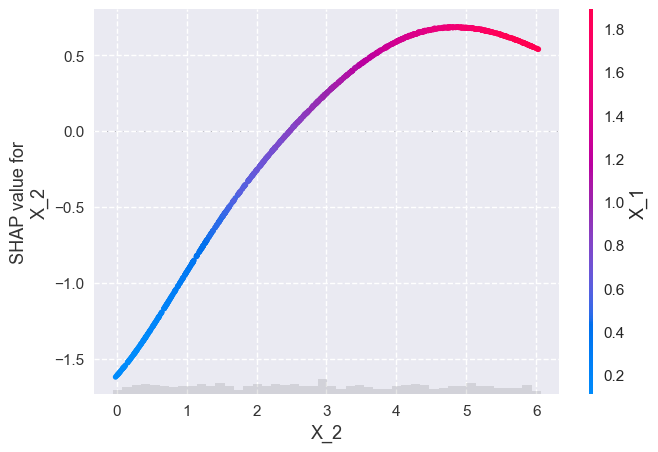

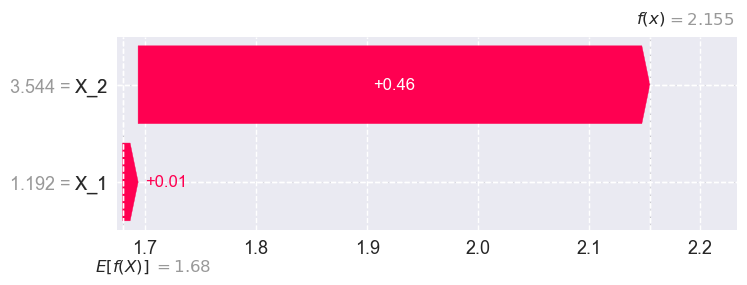

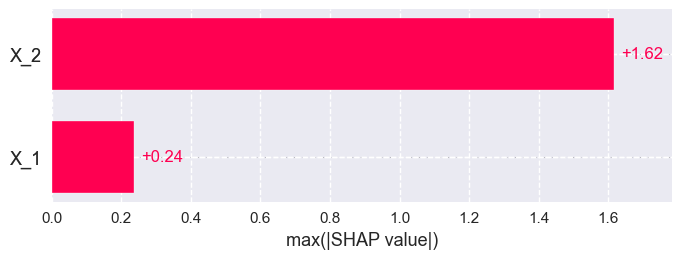

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


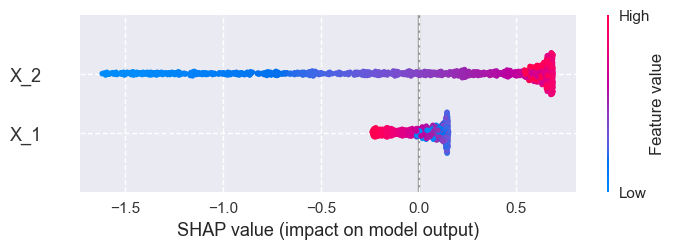

......................................................................................................................................................
MLPRegressor score: 0.978314435247977


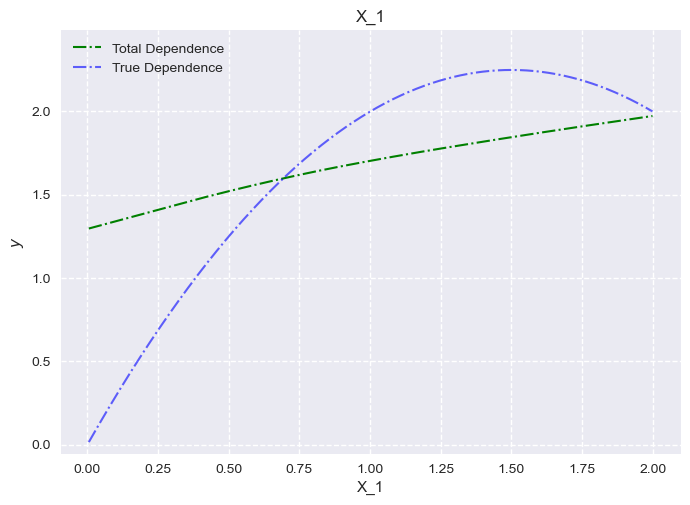

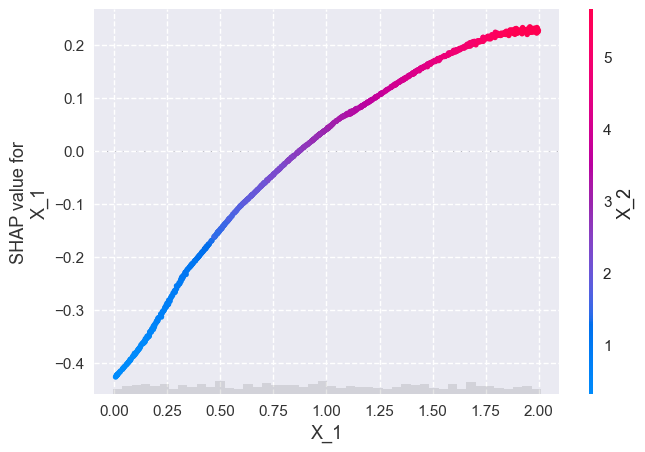

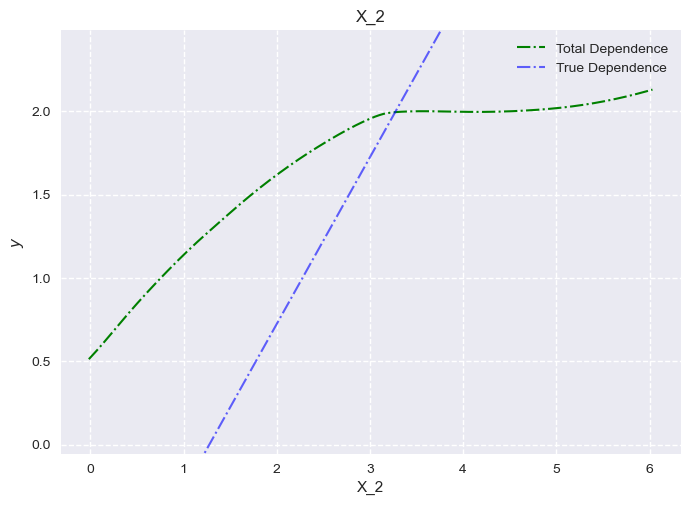

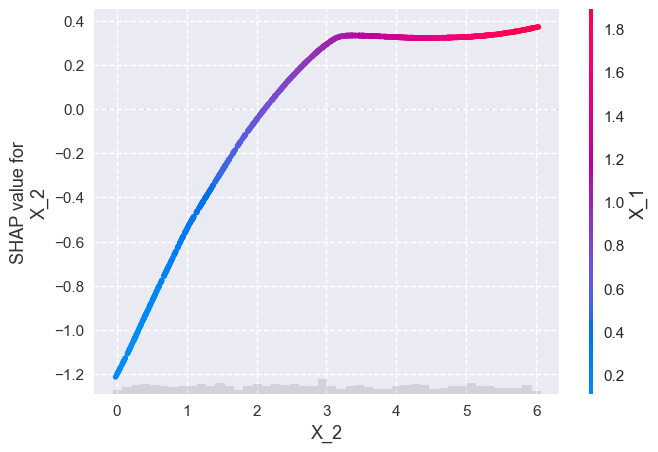

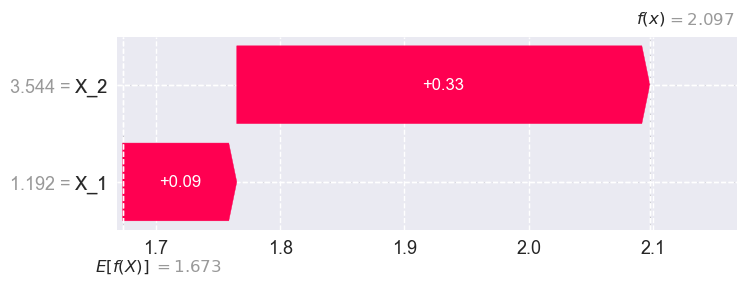

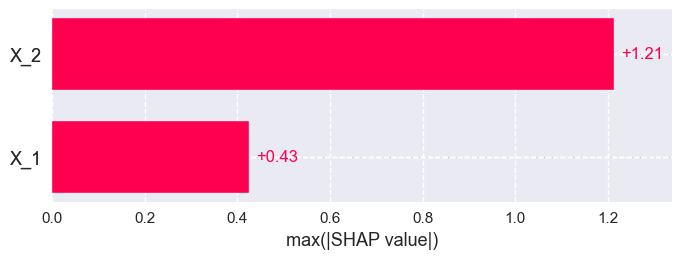

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


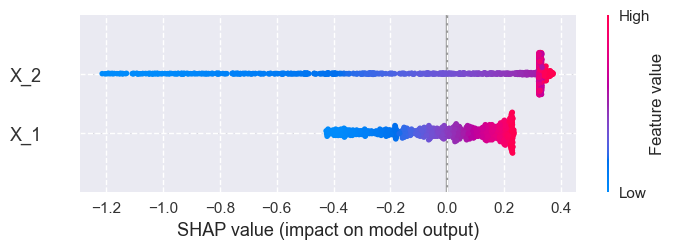

......................................................................................................................................................
------------------------------------------------------------------------------------------------------------------------------------------------------


# DataModelReversedCausality

<IPython.core.display.Latex object>

RandomForestRegressor score: 0.9999994517248836


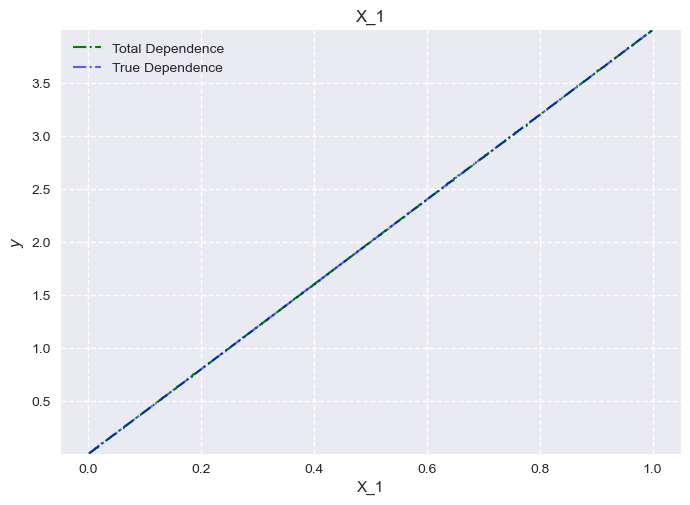

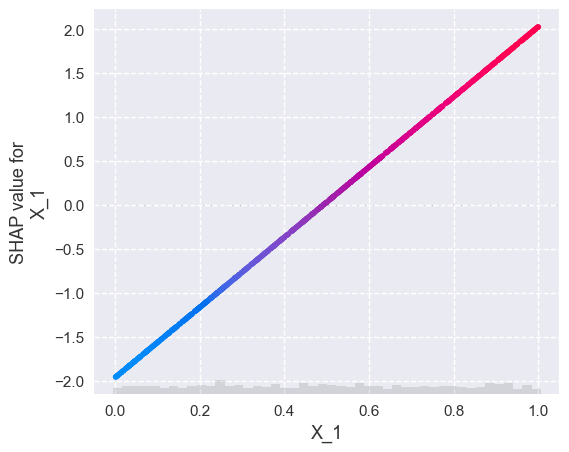

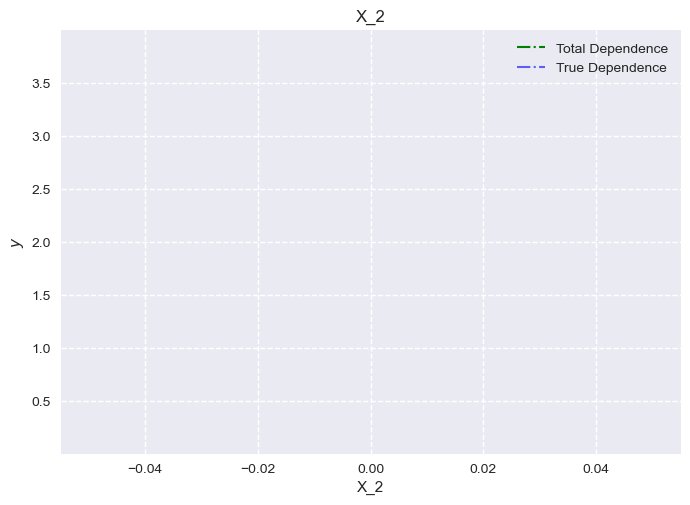

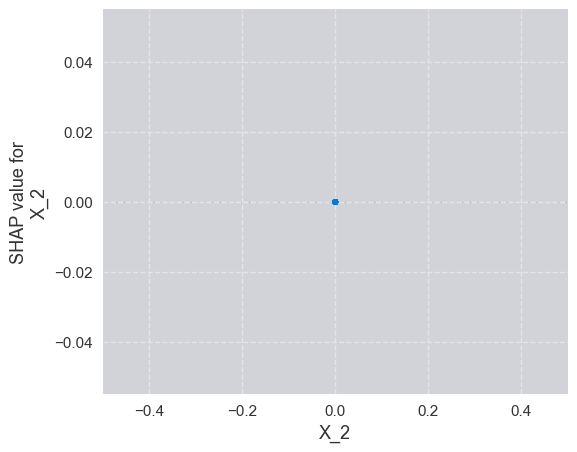

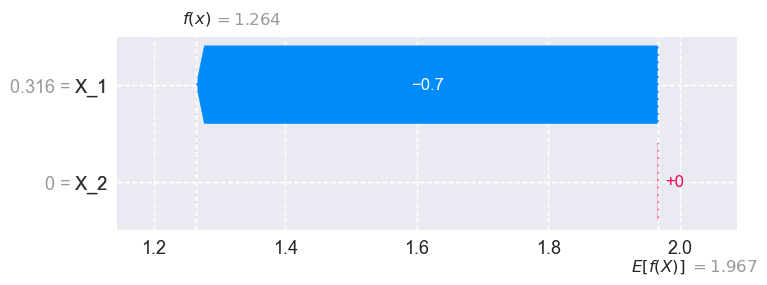

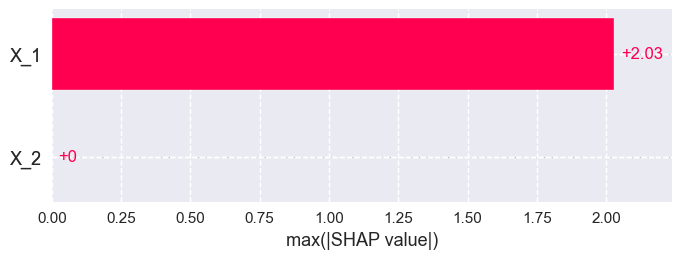

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


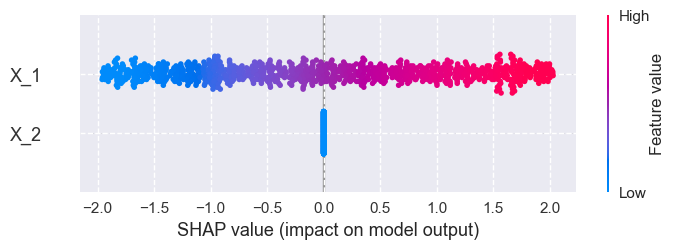

......................................................................................................................................................
SVR score: 0.9969586938553633


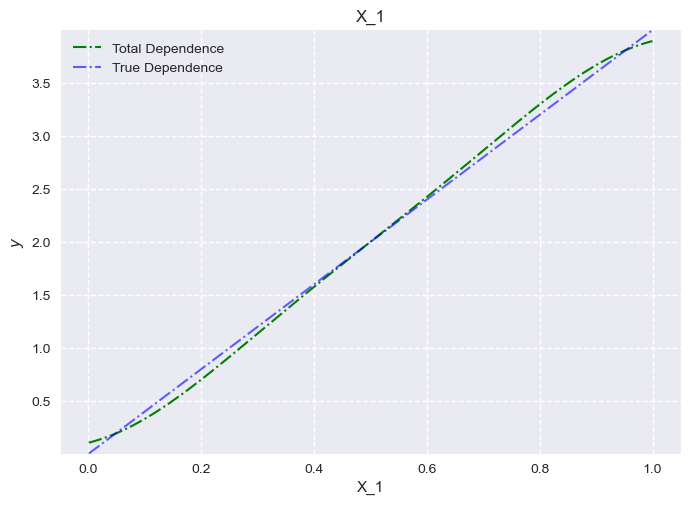

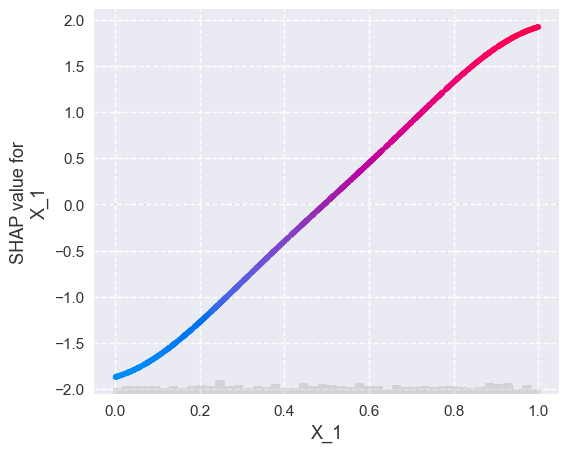

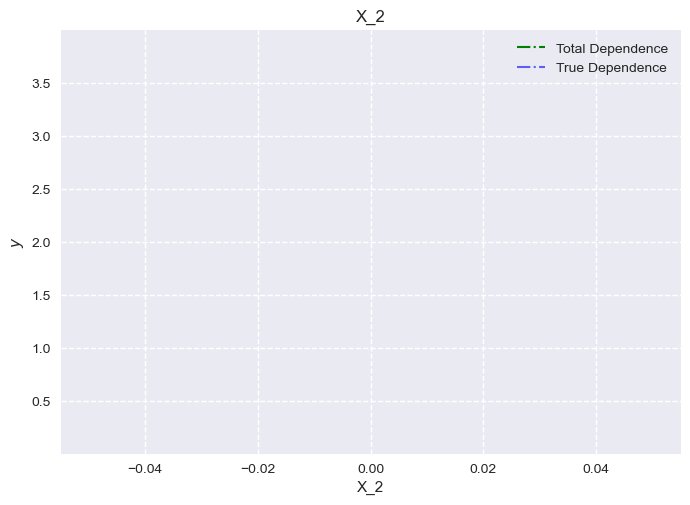

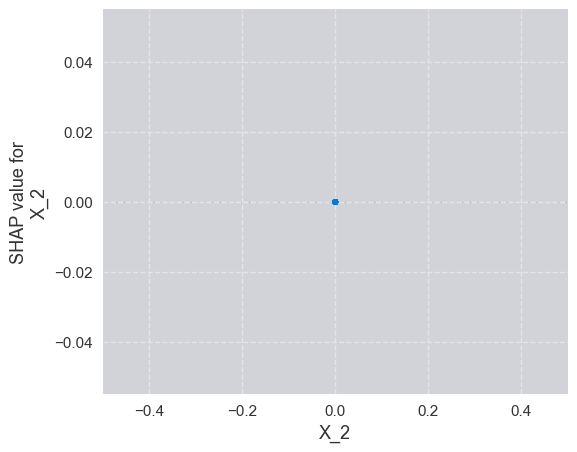

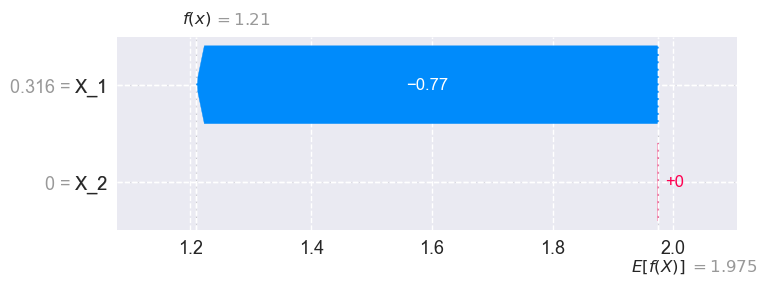

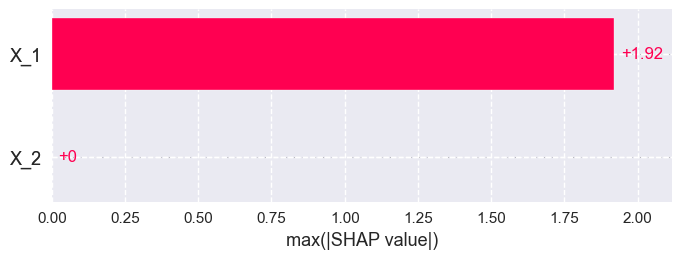

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


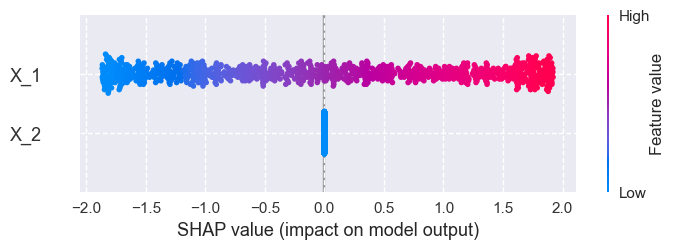

......................................................................................................................................................
MLPRegressor score: 0.9996381579161767


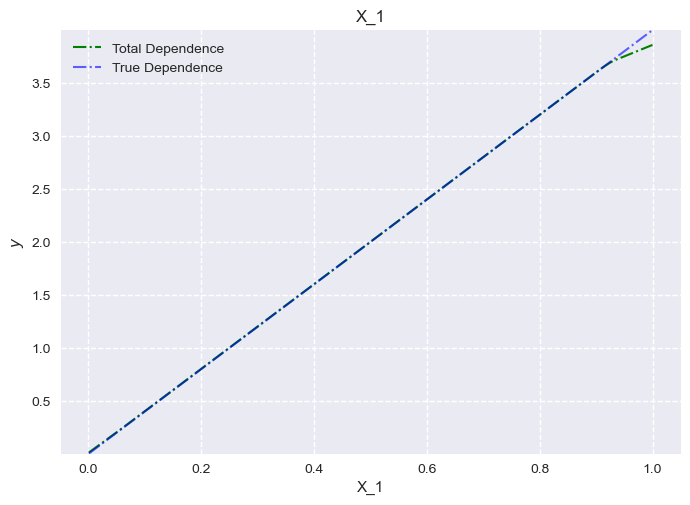

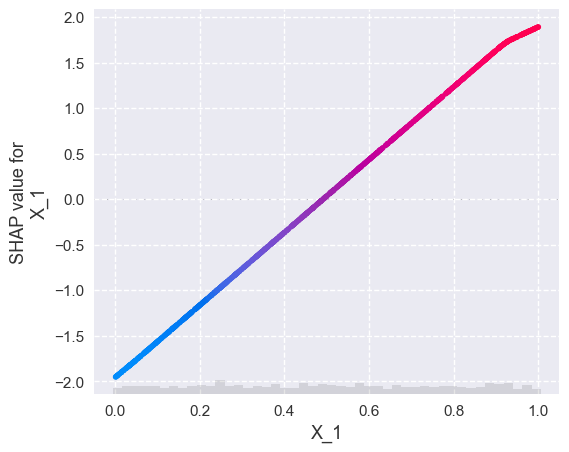

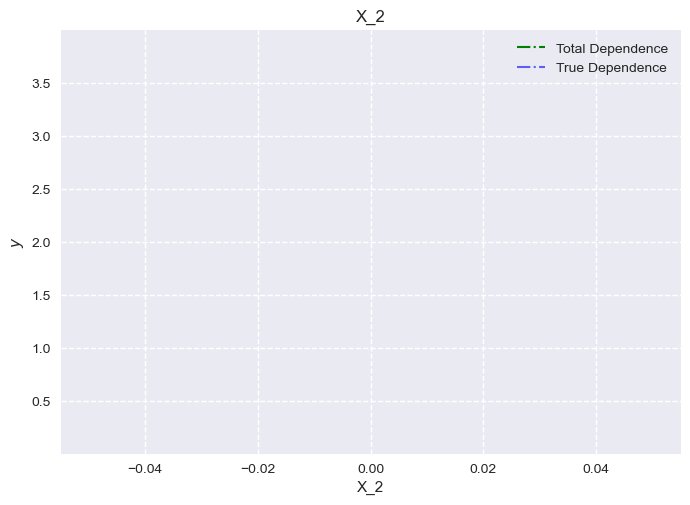

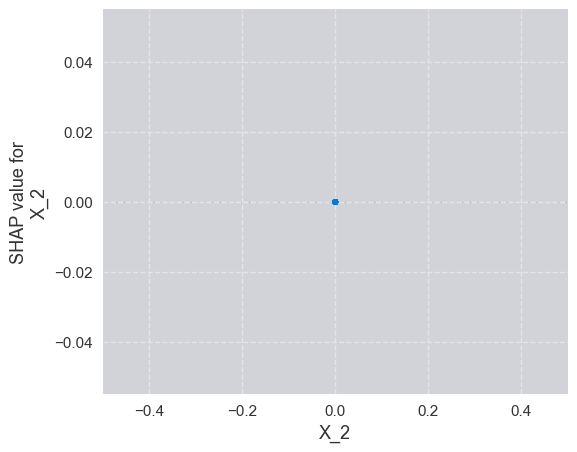

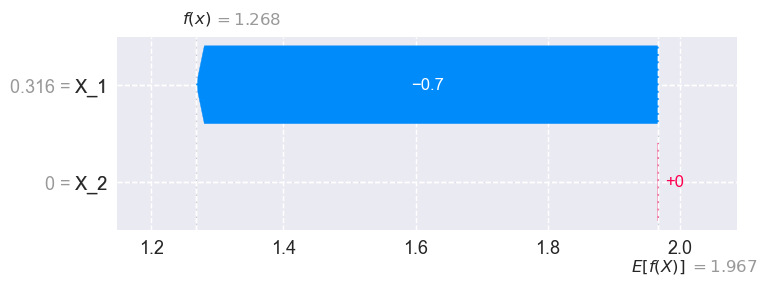

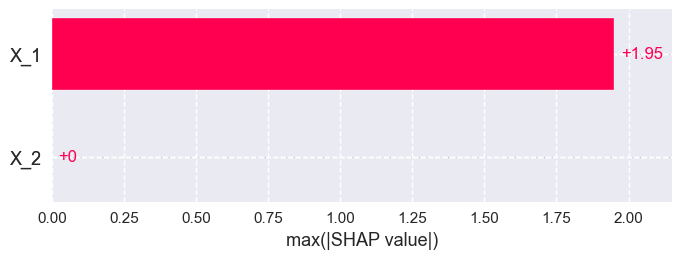

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


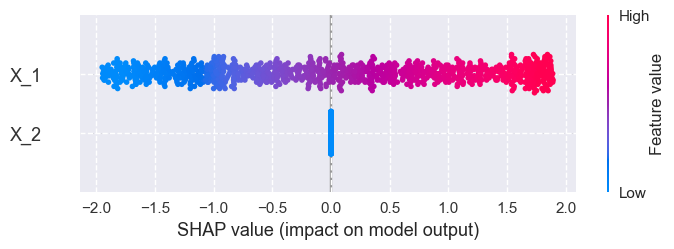

......................................................................................................................................................
------------------------------------------------------------------------------------------------------------------------------------------------------


# DataModelUnusedVar

<IPython.core.display.Latex object>

RandomForestRegressor score: 0.9999505915664635


Exact explainer: 1001it [00:12, 16.05it/s]                         


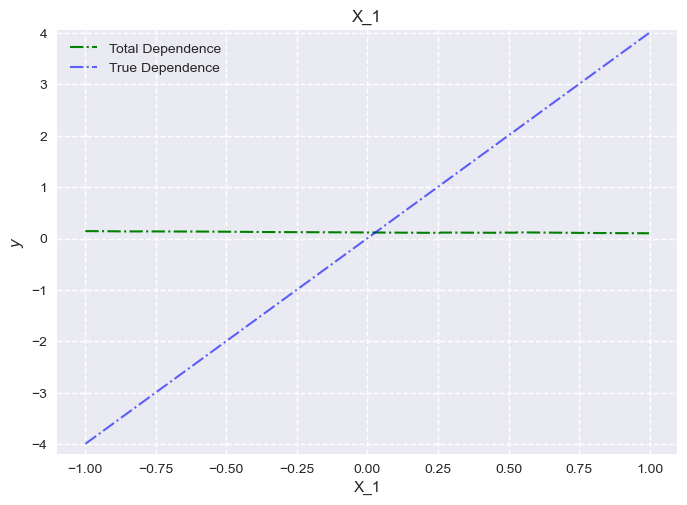

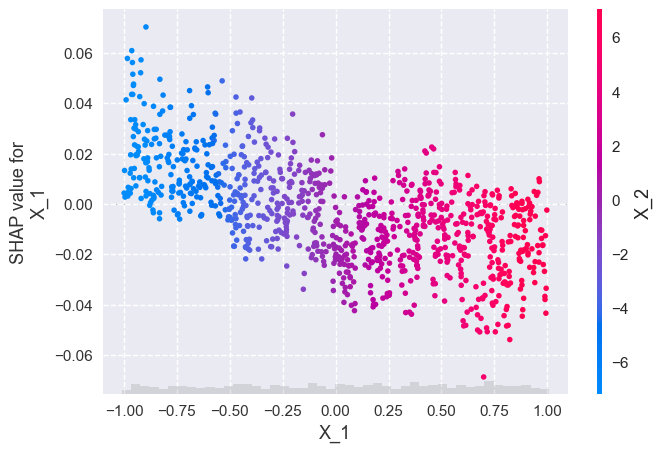

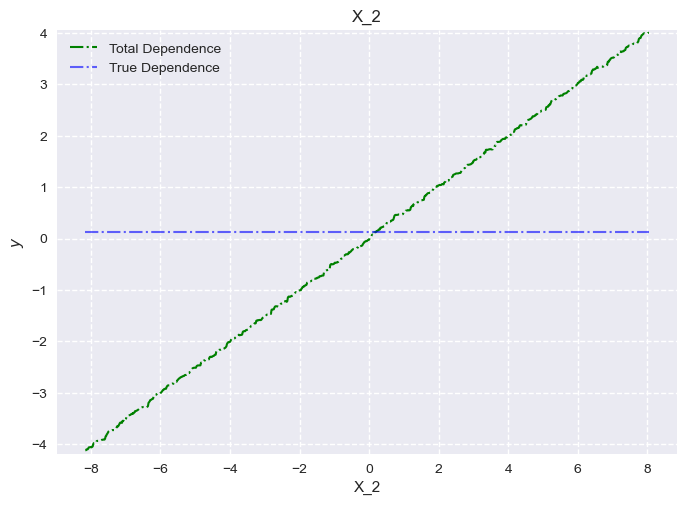

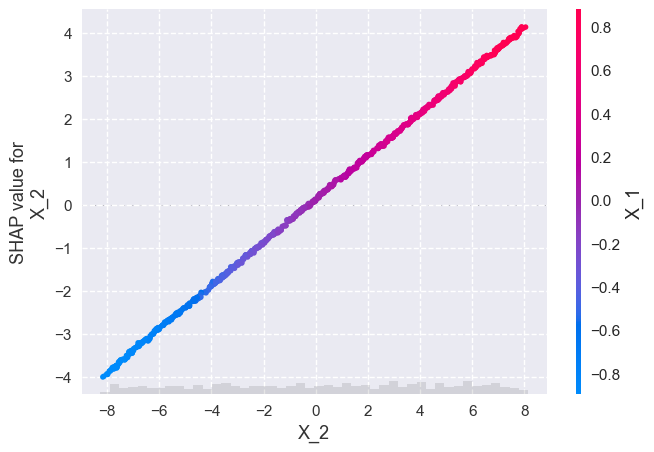

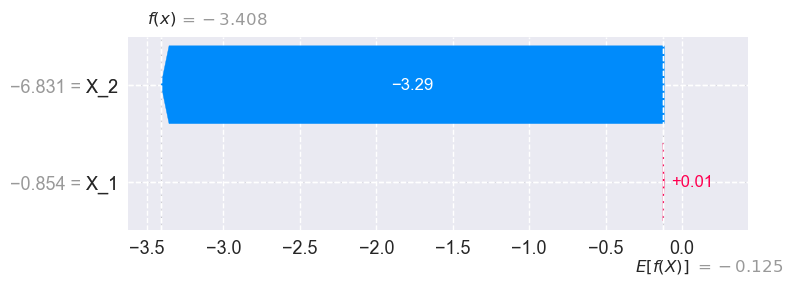

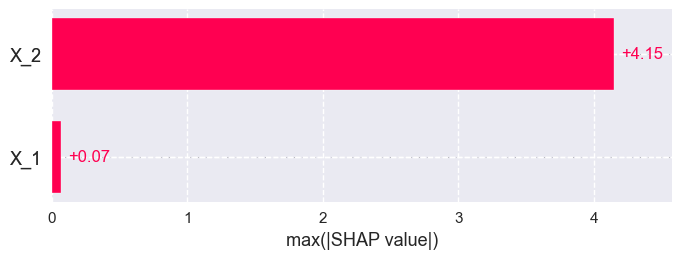

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


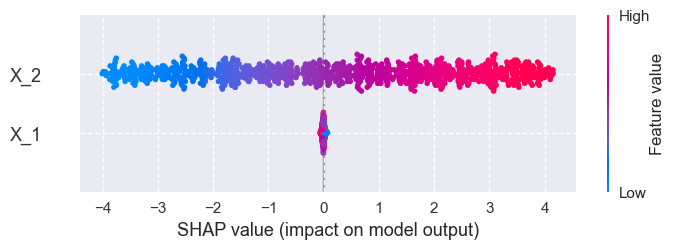

......................................................................................................................................................
SVR score: 0.9993657406000217


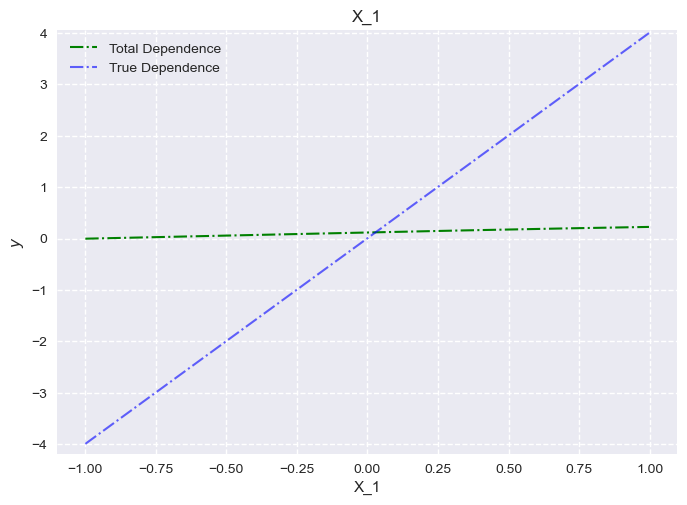

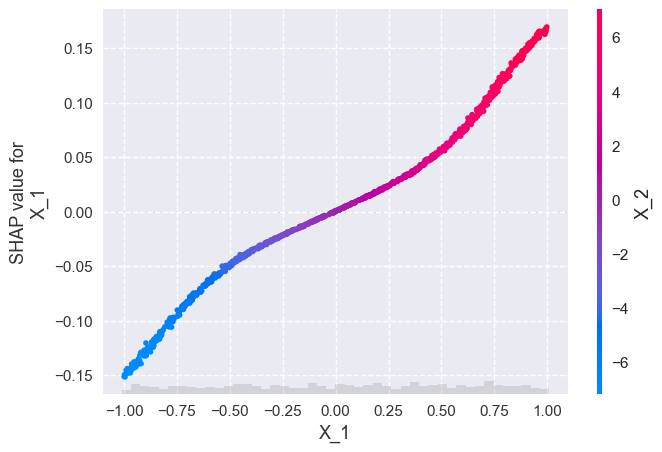

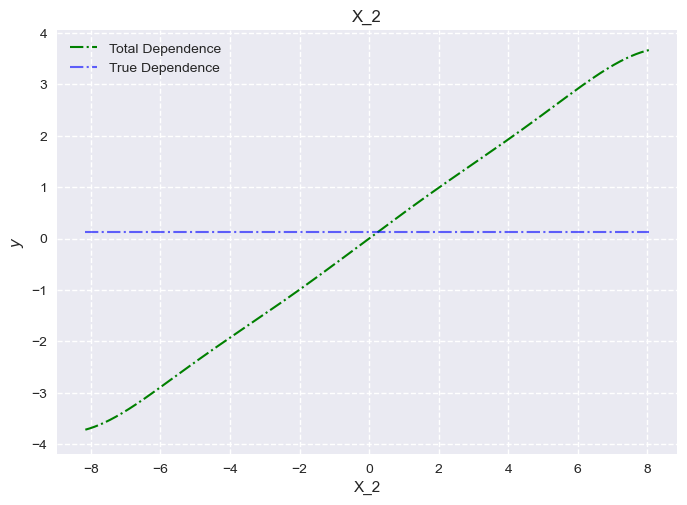

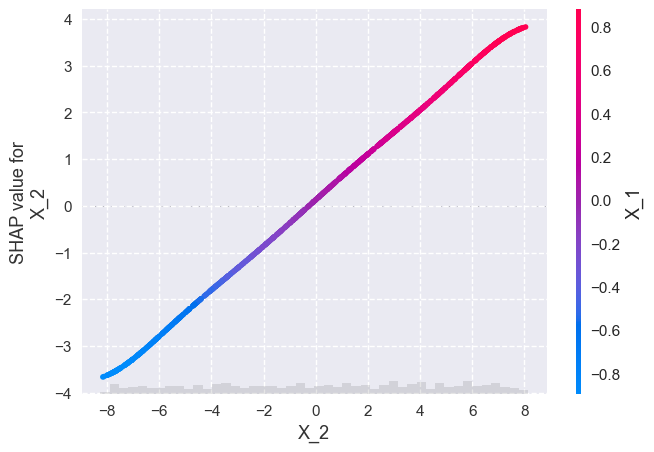

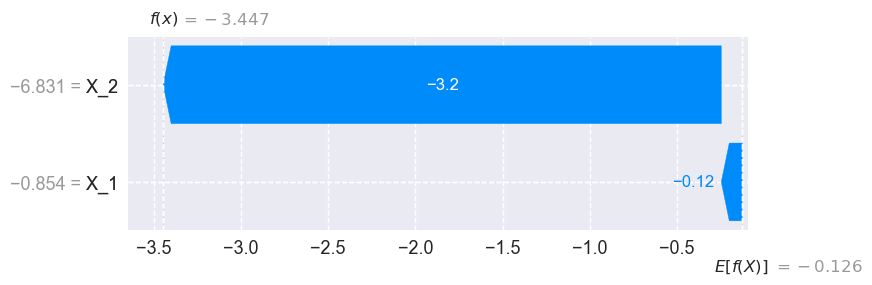

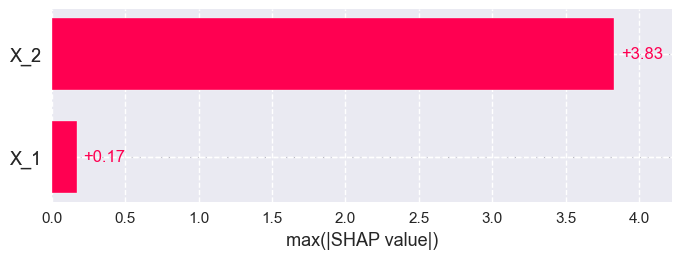

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


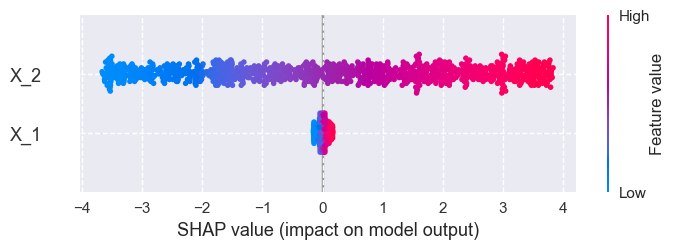

......................................................................................................................................................
MLPRegressor score: 0.9979890205937245


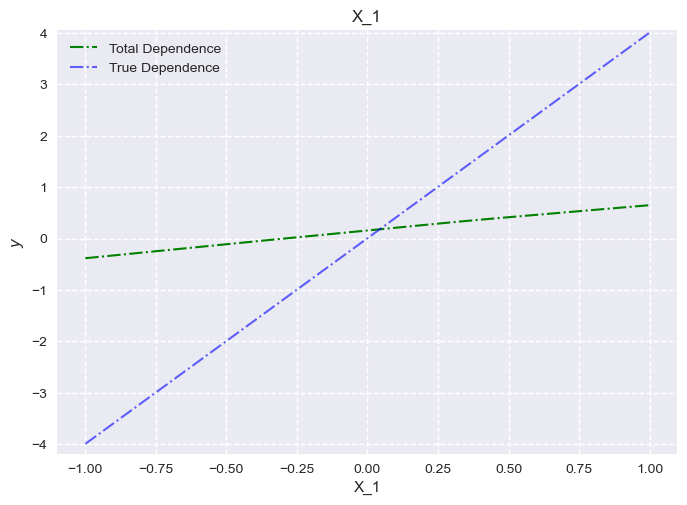

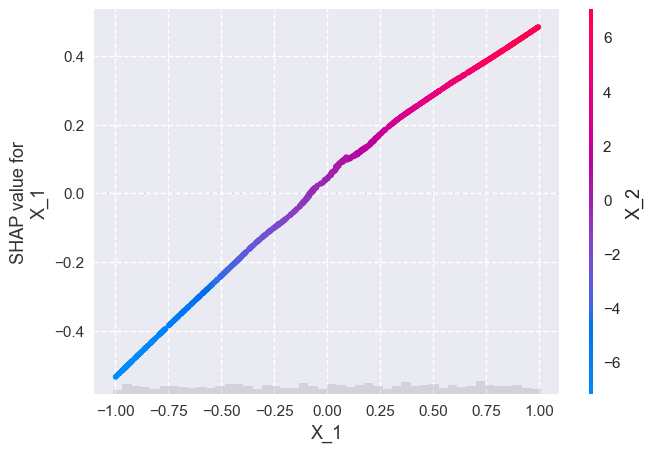

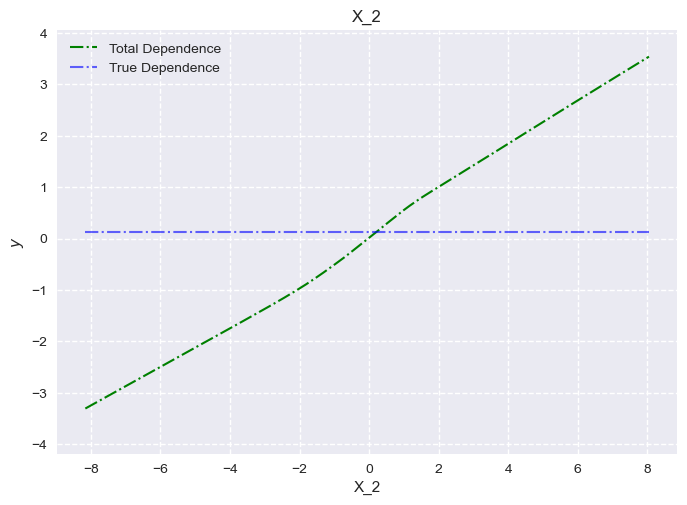

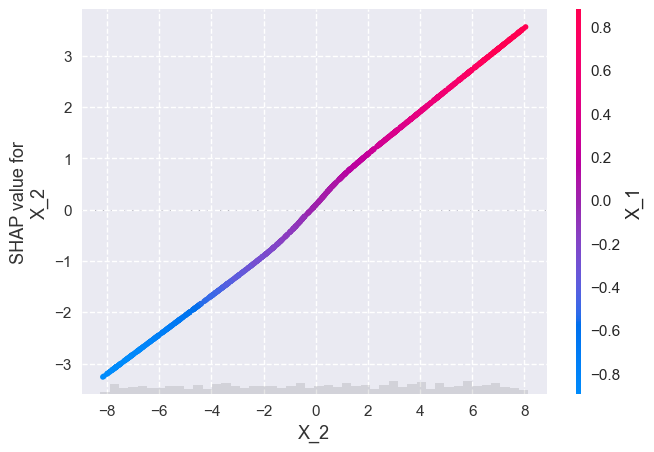

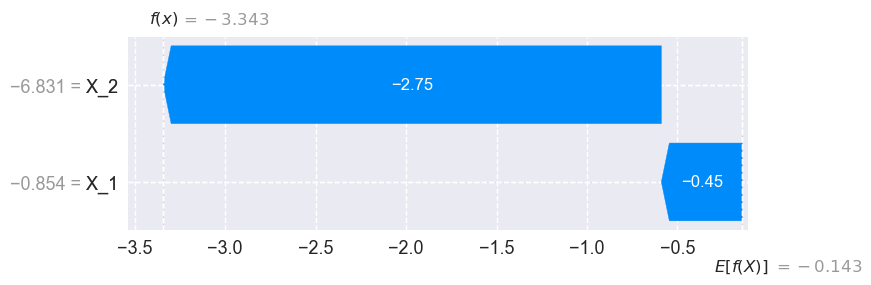

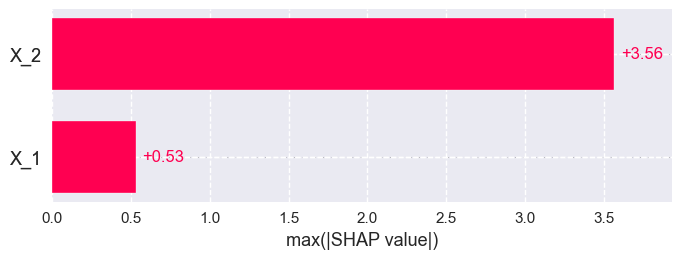

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


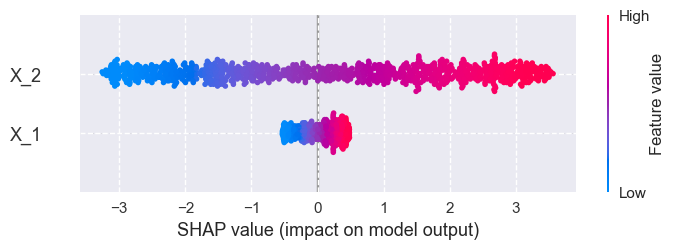

......................................................................................................................................................


In [48]:
run_experiments(ml_models, data_models)